In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [2]:
# 전처리 모듈 preprocess_ 호출하여 전처리하기
import preprocess_
pre_ = preprocess_.pre()
data = pre_.preprocess__(path="./datasets_arima/KS200.csv", slice=['날짜', '종가'], column_=['Date', 'KS200'])

/Users/jeon-youseok/Desktop/ubion/ubion_hackaton/---/Project_mini_re-main 2/arima/preprocess_.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 1.0, 'KS200 Trend')

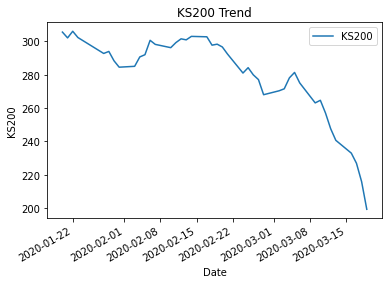

In [3]:
# xticks에 날짜를 표시하기 위해 Date열을 데이터프레임에 인덱스로 넣어주고 기존의 Date열 삭제
data_ = data[('2020-01-19' < data['Date']) & (data['Date'] <= '2020-03-19')]
data_.set_index(data_['Date'], inplace=True)
data_.drop('Date', axis=1, inplace=True)
data_.plot()

# 유석님이 말씀하신 2020-01-19 ~ 2020-03-19 사이의 코스피200지수 
plt.ylabel("KS200")
plt.title("KS200 Trend")

In [4]:
# 1월 19일은 일요일 존재 X
# 1월19일 부터 2월 17일을 train 시킨 경우
train = data[('2020-01-19' < data['Date']) & (data['Date'] <= '2020-02-17')]
target = data[('2020-02-17' < data['Date']) & (data['Date'] <= '2020-03-19')]

# xticks에 날짜를 표시하기 위해 Date열을 데이터프레임에 인덱스로 넣어주고 기존의 Date열 삭제
train.set_index(train['Date'], inplace=True)
train.drop('Date', axis=1, inplace=True)
train = np.log1p(train)
target.set_index(target['Date'], inplace=True)
target.drop('Date', axis=1, inplace=True)
target = np.log1p(target)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# 1월 19일은 일요일 존재 X
# 1월1일 부터 2월 17일을 train 시킨 경우
# 혹시 더 많은 데이터를 train 시킬 경우 예측 결과가 차이가 날까 라는 의문에서 훈련기간을 1월 1일부터로 설정한 모델을 만들기 위해 따로 만들었고 해당 모델의 데이터들은 데이터뒤에 _가 붙어있다.
train_ = data[('2020-01-01' < data['Date']) & (data['Date'] <= '2020-02-17')]

# xticks에 날짜를 표시하기 위해 Date열을 데이터프레임에 인덱스로 넣어주고 기존의 Date열 삭제
train_.set_index(train_['Date'], inplace=True)
train_.drop('Date', axis=1, inplace=True)
train_ = np.log1p(train_)

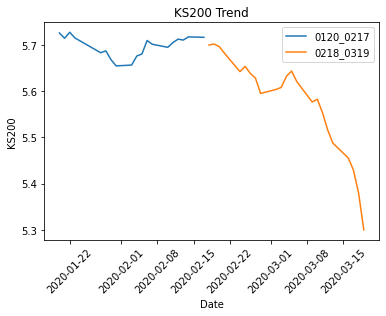

In [6]:
# 1월 19일은 일요일 존재 X
# 1월19일 부터 2월 17일을 train 시킨 경우
plt.plot(train)
plt.plot(target)

# rotation 45를 넣지 않으면 xtick의 날짜끼리 겹쳐서 제대로 보이지 않음
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('KS200')
plt.title('KS200 Trend')
plt.legend(['0120_0217', '0218_0319'])
plt.show()

In [7]:
# 1월19일 부터 2월 17일까지의 데이터 차수 선정
kpss_diffs = ndiffs(train['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 3


In [8]:
# 1월1일 부터 2월 17일까지의 데이터 차수 선정
kpss_diffs_ = ndiffs(train_['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs_ = ndiffs(train_['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs_ = max(adf_diffs_, kpss_diffs_)

print(f"추정된 차수 d = {n_diffs_}")

추정된 차수 d = 3


In [9]:
# 1월19일 부터 2월 17일을 train 시킨 경우
model = pm.auto_arima(y = train['KS200']        # 데이터
                      , d = 3            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-60.143, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-65.091, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=-72.045, Time=0.04 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-72.873, Time=0.12 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=-74.330, Time=0.05 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=-72.016, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=-71.824, Time=0.06 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=-69.384, Time=0.11 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=-68.268, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=-72.808, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=-71.561, Time=0.08 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.776 seconds


In [10]:
# 1월1일 부터 2월 17일을 train 시킨 경우
model_ = pm.auto_arima(y = train_['KS200']        # 데이터
                      , d = 3            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-112.205, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-129.103, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=-139.210, Time=0.01 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=-142.420, Time=0.04 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=-140.580, Time=0.10 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=-145.680, Time=0.07 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=-147.763, Time=0.04 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-146.686, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=-144.484, Time=0.05 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=-146.936, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=-143.708, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=-143.289, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.590 seconds


In [11]:
# 1월19일 부터 2월 17일을 train 시킨 경우
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(2, 3, 1)   Log Likelihood                  41.165
Date:                Sat, 30 Apr 2022   AIC                            -74.330
Time:                        10:57:16   BIC                            -71.239
Sample:                             0   HQIC                           -74.172
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6596      0.316     -2.089      0.037      -1.278      -0.041
ar.L2         -0.3955      0.295     -1.342      0.180      -0.973       0.182
ma.L1         -0.9340      0.760     -1.228      0.2

In [12]:
# 1월1일 부터 2월 17일을 train 시킨 경우
print(model_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(2, 3, 1)   Log Likelihood                  77.881
Date:                Sat, 30 Apr 2022   AIC                           -147.763
Time:                        10:57:16   BIC                           -142.434
Sample:                             0   HQIC                          -146.134
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7361      0.212     -3.478      0.001      -1.151      -0.321
ar.L2         -0.3251      0.210     -1.551      0.121      -0.736       0.086
ma.L1         -0.9629      0.358     -2.691      0.0

### Ljung-Box(=Prob(Q)) :  일정 기간 동안 일련의 관측치가 랜덤이고 독립적인지 여부를 검사하는데 사용된다
    - 자기 상관 관계에서 시점간의 상관 관계를 의미하며, 자기 상관관계로 인하여 시계열 모형의 정확도를 떨어뜨리는 원인이 되기도 한다.
    - 귀무가설 : 자기상관성이 없다. 상관계수=0 / 대립가설 : 자기상관성이 있다. 상관계수≠0
    - Prob(Q)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 자기상관성이 존재한다는 의미이다.

### Jarque-Bera(=Prob(JB)) : 왜도와 첨도가 정규분포로 보기에 적합한지에 대한 적합도 검정에 사용한다
    - 귀무가설 : 데이터는 정규분포를 따른다. / 대립가설 : 데이터는 정규분포를 따르지 않는다.
    - Prob(JB)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 데이터는 정규분포를 따르지 않는다는 의미이다.

### Heteroskedasticity(=Prob(H)) : 각 시간대 별 잔차의 분산이 일정한지 보는 테스트
    - 귀무가설 : 잔차의 분산이 일정하다 / 대립가설 잔차의 분산이 일정하지 않다.
    - Prob(H)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 잔차의 분산이 일정하지 않다는 의미이다.

### Skew (왜도) : 분포가 정규분포에 비해 얼마나 비대칭인지 나타내는 척도

### Kurtosis (첨도) = 샘플의 점수가 평균을 중심으로 가까링 몰려 있을수록 분포의 정점은 더욱 뾰족한 모양. 즉 첨도가 커진다.


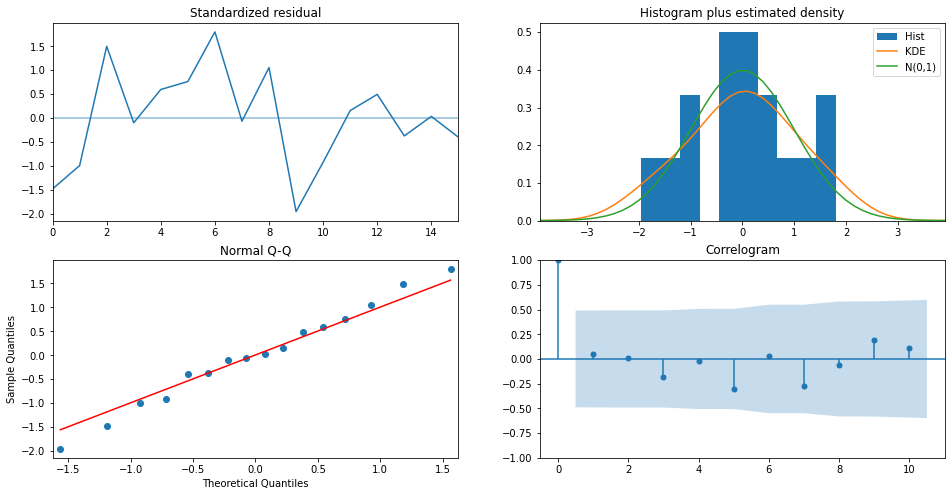

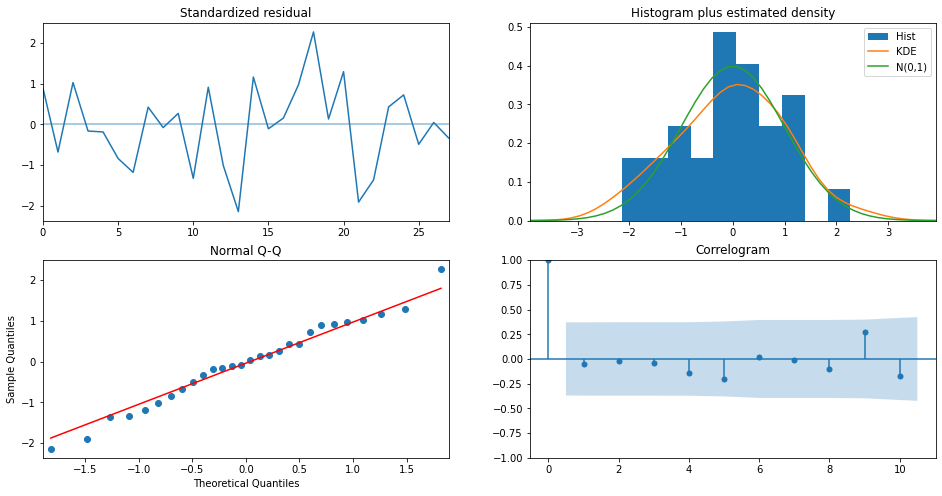

In [13]:
# 1월19일 부터 2월 17일을 train 시킨 경우
model.plot_diagnostics(figsize=(16, 8))
# 1월1일 부터 2월 17일을 train 시킨 경우
model_.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Standardized residual : 잔차를 시계열로 그린 것
#### Correlogram : 잔차에 대한 ACF와 허용범위를 나타낸 것
    - ACF란? 자기상관함수 (AutoCorrelation Function) 으로써 시차에 따른 일련의 자기상관을 의미하며 시차가 커질 수록 0에 가까워진다. 정상 시계열은 빠르게 0으로 수렴하며, 비정상 시계열은 천천히 감소하고 종종 양의 큰 값을 가진다
#### Histogram plus estimated density : 잔차의 히스토그램을 그려 정규분포 N(0,1)과 밀도를 추정한 그래프를 같이 겹쳐서 보여주는 것. 
#### Normal Q-Q : 수집데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프로 데이터의 정규성 가정에 대한 검토를 가능하게 한다. 모집단이 정규성을 따른다면 직선의 형태로 그려지게 된다.

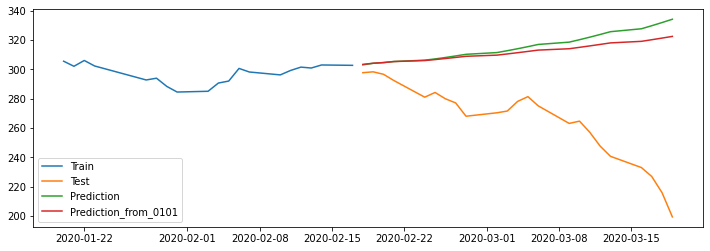

In [14]:
# 테스트 데이터 개수만큼 예측 (1월19일 부터 2월 17일을 train 시킨 경우)
y_predict = model.predict(n_periods=len(target['KS200'])) 
y_predict = pd.DataFrame(y_predict, index = target['KS200'].index, columns=['Prediction'])
# 1월1일 부터 2월 17일을 train 시킨 경우
y_predict_ = model_.predict(n_periods=len(target['KS200'])) 
y_predict_ = pd.DataFrame(y_predict_, index = target['KS200'].index, columns=['Prediction_'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(np.expm1(train['KS200']), label='Train')        # 훈련 데이터
plt.plot(np.expm1(target['KS200']), label='Test')          # 테스트 데이터
plt.plot(np.expm1(y_predict), label='Prediction')  # 예측 데이터 (1월19일부터훈련)
plt.plot(np.expm1(y_predict_), label='Prediction_from_0101') # 예측 데이터 (1월1일부터훈련)
plt.legend()
plt.show()

In [15]:
# 관측치를 추가함으로써 모형을 refresh하고 이로 인해 AIC, 로그 가능도가 다시 계산되고 가장 마지막 관측치가 업데이트된다
# AIC(Akaike Information Criterion)란? 두 확률분포 사이의 차이를 표현한 것. 실제 데이터의 분포와 모형이 예측하는 분포 사이의 차이
# AIC가 작다는 것은 모형이 자료의 진짜 분포와 비슷하게 생겼다는 것
# 쉽게 설명한 곳 : https://student9725.tistory.com/28
# 좀 더 깊게 설명한 곳 : https://rk1993.tistory.com/entry/AIC-BIC-Mallows-Cp-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0
def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [16]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in target['KS200']:
    fc, conf = forecast_one_step(model)
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [17]:
forecasts_ = []
y_pred_ = []
pred_upper_ = []
pred_lower_ = []

for new_ob_ in target['KS200']:
    fc_, conf_ = forecast_one_step(model_)
    y_pred_.append(fc_)
    pred_upper_.append(conf_[1])
    pred_lower_.append(conf_[0])

    ## 모형 업데이트 !!
    model_.update(new_ob_)

In [18]:
pd.DataFrame({"test": np.expm1(target['KS200']), "pred": np.expm1(y_pred)})

,test,pred
Date,,
2020-02-18,297.74,303.124116
2020-02-19,298.33,296.493205
2020-02-20,296.65,297.095397
2020-02-21,292.42,293.945712
2020-02-24,281.02,290.560707
2020-02-25,284.24,274.568356
2020-02-26,279.94,280.876054
2020-02-27,277.09,274.202898
2020-02-28,268.02,276.263893


In [19]:
pd.DataFrame({"test": np.expm1(target['KS200']), "pred": np.expm1(y_pred_)})

,test,pred
Date,,
2020-02-18,297.74,303.401050
2020-02-19,298.33,296.778410
2020-02-20,296.65,296.219698
2020-02-21,292.42,294.717900
2020-02-24,281.02,290.605852
2020-02-25,284.24,275.320785
2020-02-26,279.94,278.944837
2020-02-27,277.09,276.297636
2020-02-28,268.02,275.495922


In [20]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(2, 3, 1)   Log Likelihood                  94.108
Date:                Sat, 30 Apr 2022   AIC                           -180.216
Time:                        10:57:18   BIC                           -173.562
Sample:                             0   HQIC                          -177.829
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5950      0.208     -2.864      0.004      -1.002      -0.188
ar.L2         -0.3109      0.194     -1.601      0.109      -0.692       0.070
ma.L1         -0.9354      0.205     -4.566      0.0

In [21]:
print(model_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 3, 1)   Log Likelihood                 128.726
Date:                Sat, 30 Apr 2022   AIC                           -249.452
Time:                        10:57:18   BIC                           -241.725
Sample:                             0   HQIC                          -246.500
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6247      0.162     -3.862      0.000      -0.942      -0.308
ar.L2         -0.2663      0.150     -1.776      0.076      -0.560       0.028
ma.L1         -0.9630      0.160     -6.026      0.0

In [22]:
## 1월1일부터 학습시킨 모델의 예측 결과와 1월19일부터 학습시킨 모델의 예측결과가 그래프상으로는 두드러지게 나타나지 않았다.
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    
    # 훈련 데이터(1월 1일부터)------------------------------------------------------------
    go.Scatter(x = train_['KS200'].index, y = np.expm1(train_['KS200']), name = "Train", mode = 'lines'
              ,line=dict(color = 'violet'))
    # 훈련 데이터(1월 19일부터)-----------------------------------------------------------
    , go.Scatter(x = train['KS200'].index, y = np.expm1(train['KS200']), name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터-----------------------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(target['KS200']), name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값(1월 1일 부터 학습)-----------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(y_pred_), name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'skyblue', dash = 'dot', width=3))     
        # 예측값(1월 19일 부터 학습)-----------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(y_pred), name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))            
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = target['KS200'].index.tolist() + target['KS200'].index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(2,3,1)모형")
fig.show()



In [23]:
# 학습을 1월 19일부터 시킨 모델과 1월 1일부터 시킨 모델의 차이 평균
# 1-20일을 더 학습시켰지만 크게 차이는 없었다?
np.mean([x-y for x,y in zip(np.expm1(y_pred), np.expm1(y_pred_))])

-0.06209256088197519

In [24]:
# 학습을 1월 19일부터 시킨경우
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.expm1(target['KS200']), np.expm1(y_pred)):.3f}")
# MAPE: 0.792

MAPE: 1.882


In [25]:
# 학습을 1월 19일부터 시킨경우
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.expm1(target['KS200']), np.expm1(y_pred_)):.3f}")
# MAPE: 0.792
# MAPE 차이로는 학습데이터를 조금 늘렸을 때 유의미한 차이가 없었다?

MAPE: 1.847


In [26]:
np.expm1(y_pred_)

array([303.40104995, 296.77841014, 296.21969798, 294.71790032,
       290.60585234, 275.32078497, 278.94483696, 276.29763646,
       275.49592171, 262.79703444, 266.27356075, 269.95733355,
       281.6037703 , 285.84682455, 276.90465983, 258.06318122,
       258.10145792, 251.63314109, 242.14377991, 232.4969915 ,
       225.07120989, 220.01176542, 207.51980268])

### MAPE (mean absolute precentage error) MAE를 퍼센트로 변환한 것이다
    - MAE와 마찬가지로 MSE보다 특이치에 robust하다(상대적으로 영향을 덜 받는다--MSE는 제곱을 하기 때문)
    - MAE와 마찬가지로 절대값을 취하기 때문에 실제보다 높은지 낮은지 알 수 없다는 단점
